# PRMS v6 BMI coupling - runtime interaction demo

* This demonstration will illustrate how the coupled surface-, soil-, groundwater-, and streamflow-BMIs can be interacted with at runtime.
    * Some initial setup including matching an HRU polygon shapefile with order of HRUs in input file
    * Visualizing results by mapping onto geopandas dataframe
    * Using web-based data-services to drive climate forcing
    * User controled forcing to inspect HRU response


In [1]:
%matplotlib inline
import numpy as np
from pymt.models import PRMSSurface, PRMSSoil, PRMSGroundwater, PRMSStreamflow
from pathlib import Path
import geopandas as gpd
import pandas as pd
from gridmet import Gridmet
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt
import helper



➡ models: Avulsion, Plume, Sedflux3D, Subside, Rafem, PRMSSurface, PRMSStreamflow, PRMSSoil, PRMSGroundwater, FrostNumber, Ku, Hydrotrend, GIPL, ECSimpleSnow, Cem, Waves


In [2]:
# CSDMS JupyterHub set path to HRU and streamsegment shapefiles
hru_shp = '/data/prms/GIS/nhru_10U.shp'
hru_strmseg = '/data/prms/GIS/nsegment_10U.shp'
# set path to Gridmet weights file for mapping Gridmet gridded data to HRU
weight_file = '/data/prms/weights.csv'

# If using notebook not in CSDMS JupyterHub.  See README for instruction on where to 
# get the data and  uncomment out the following lines
# hru_shp = './GIS/nhru_10U.shp'
# hru_strmseg = './GIS/nsegment_10U.shp'
# # set path to Gridmet weights file for mapping Gridmet gridded data to HRU
# weight_file = './GIS/weights.csv'

In [3]:
run_dir = '../prms/pipestem'
config_surf= 'control_surface.simple1'
config_soil = 'control_soil.simple1'
config_gw = 'control_groundwater.simple1'
config_sf = 'control_streamflow.simple1'
print(Path(run_dir).exists())
print((Path(run_dir) / config_surf).exists())
print((Path(run_dir) / config_soil).exists())
print((Path(run_dir) / config_gw).exists())
print((Path(run_dir) / config_sf).exists())
msurf = PRMSSurface()
msoil = PRMSSoil()
mgw = PRMSGroundwater()
msf = PRMSStreamflow()

print(msurf.name, msoil.name, mgw.name, msf.name)

True
True
True
True
True
prms6-surface-BMI prms6-BMI-SOIL prms6-groundwater-BMI prms6-streamflow-BMI


In [4]:
msurf.initialize(config_surf, run_dir)
msoil.initialize(config_soil, run_dir)
mgw.initialize(config_gw, run_dir)
msf.initialize(config_sf, run_dir)

--- 
### Open shapefile for the pipestem HRUs and stream segments and make sure the order in geopandas dataframe match the order from model components so they can be easily maps.  Shapefiles are used for spatial plots of the prms6 variables.

    - get_gdf and get_gdf_stream can be found in helper.py

---

In [5]:
gdf_ps = helper.get_gdf(hru_shp, msurf)
print(gdf_ps.head())
gdf_streams = helper.get_gdf_streams(hru_strmseg, msurf)
print(gdf_streams.head())

        POI_ID  hru_id_nat  hru_id_reg region  \
2290  11498758       57874        2291    10U   
2291  11498758       57875        2292    10U   
2294  11499032       57878        2295    10U   
2297  11499032       57881        2298    10U   
2284  11499050       57868        2285    10U   

                                               geometry  tindex  
2290  POLYGON ((-99.15848 47.34603, -99.15848 47.346...       0  
2291  POLYGON ((-99.18303 47.44457, -99.18263 47.444...       1  
2294  POLYGON ((-99.46894 47.43525, -99.46931 47.435...       2  
2297  POLYGON ((-99.46934 47.45073, -99.46932 47.450...       3  
2284  POLYGON ((-99.13075 47.32545, -99.13058 47.325...       4  
          POI_ID  tosegment  seg_id_nat  seg_id_reg region  \
1676  11498758.0       1682       30113        1677    10U   
1677  11499032.0       1680       30114        1678    10U   
1678  11499050.0       1683       30115        1679    10U   
1679  11499054.0       1681       30116        1680    10U   

---

### Open climate driver data used by PRMS and plot the first days data.  

---

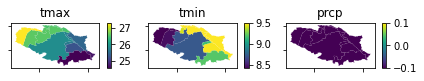

In [6]:
clim_file = Path('../prms/pipestem/daymet.nc')
#plot climate and return clim_file as xarray object
clim = helper.plot_climate2(clim_file, gdf_ps, msurf)

---

### Search for an precipitation event to look at model output below

---

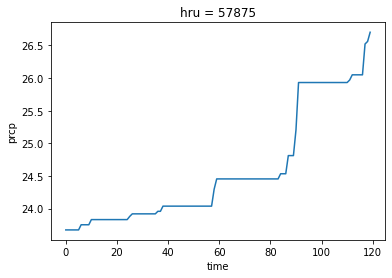

In [7]:
cum_sum = clim.cumsum(dim='time')
cum_sum.prcp.isel(hru=1)[365:485].plot()


---

Get some model time information

---

In [8]:
# Get time information from the model.
print(msurf.get_value('nowtime'))
print(msoil.var['nowtime'].data)
print(f'Start time: {msurf.start_time}')
print(f'End time: {msurf.end_time}')
print(f'Current time : {msurf.time}')


[1980    1    1    0    0    0]
[1980    1    1    0    0    0]
Start time: 0.0
End time: 731.0
Current time : 0.0


---
Setup an exchange function to facilitate the coupling
___

In [9]:
soil_input_cond_vars = ['soil_rechr_chg', 'soil_moist_chg']

surf2soil_vars = ['hru_ppt', 'hru_area_perv', 'hru_frac_perv', 'dprst_evap_hru', 
                   'dprst_seep_hru', 'infil', 'sroff','potet', 'hru_intcpevap', 
                   'snow_evap', 'snowcov_area', 'soil_rechr', 'soil_rechr_max', 
                   'soil_moist', 'soil_moist_max', 'hru_impervevap' , 
                   'srunoff_updated_soil','transp_on']

soil2surf_vars = ['infil', 'sroff', 'soil_rechr', 'soil_moist']

surf2gw_vars = ['pkwater_equiv', 'dprst_seep_hru', 'dprst_stor_hru', 'hru_intcpstor',
               'hru_impervstor', 'sroff']

soil2gw_vars = ['soil_moist_tot', 'soil_to_gw', 'ssr_to_gw', 'ssres_flow']

surf2sf_vars = ['potet', 'swrad', 'sroff']

soil2sf_vars = ['ssres_flow']

gw2sf_vars = ['gwres_flow']

def soilinput(msurf, msoil, exch_vars, cond_vars, dprst_flag, imperv_flag):
    for var in exch_vars:
        msoil.set_value(var, msurf.get_value(var))
    if dprst_flag in [1, 3] or imperv_flag in [1, 3]:
        for var in cond_vars:
            msoil.set_value(var, msurf.get_value(var))

def soil2surface(msoil, msurf, exch_vars):
    for var in exch_vars:
        msurf.set_value(var, msoil.get_value(var))
        
def gwinput(msurf, msoil, mgw, surf_vars, soil_vars):
    for var in surf_vars:
        mgw.set_value(var, msurf.get_value(var))
    for var in soil_vars:
        mgw.set_value(var, msoil.get_value(var))
        
def sfinput(msurf, msoil, mgw, msf, surf_vars, soil_vars, gw_vars):
    for var in surf_vars:
        msf.set_value(var, msurf.get_value(var))
    for var in soil_vars:
        msf.set_value(var, msoil.get_value(var))
    for var in gw_vars:
        msf.set_value(var, mgw.get_value(var))

        
dprst_flag = msoil.get_value('dyn_dprst_flag')
imperv_flag = msoil.get_value('dyn_imperv_flag')

def update_coupled(msurf, msoil, mgw, msf, dprst_flag, imperv_flag):
    msurf.update()
    soilinput(msurf, msoil, surf2soil_vars, soil_input_cond_vars, dprst_flag, imperv_flag)
    msoil.update()
    soil2surface(msoil, msurf, soil2surf_vars)
    gwinput(msurf, msoil, mgw, surf2gw_vars, soil2gw_vars)
    mgw.update()
    sfinput(msurf, msoil, mgw, msf, surf2sf_vars, soil2sf_vars, gw2sf_vars)
    msf.update()

---
Run for 1-year plus 90 days just prior to preciptation event in cumulative plot above

---

In [10]:
for time in range(455):
    update_coupled(msurf, msoil, mgw, msf, dprst_flag, imperv_flag)

---
Build function to plot some variables at runtime:
example_plot():
* sroff: Surface runoff to the stream network for each HRU
* infil: Infiltration to the capillary reservoir for each HRU
* soil_moist_tot: Total soil-zone storage (soil_moist + ssres_stor) for each HRU

---

---
Run for 7-days and inspect results

---

[1981    3   31    0    0    0] 1981-03-31 00:00:00
[1981    4    1    0    0    0] 1981-04-01 00:00:00
[1981    4    2    0    0    0] 1981-04-02 00:00:00
[1981    4    3    0    0    0] 1981-04-03 00:00:00
[1981    4    4    0    0    0] 1981-04-04 00:00:00
[1981    4    5    0    0    0] 1981-04-05 00:00:00
[1981    4    6    0    0    0] 1981-04-06 00:00:00


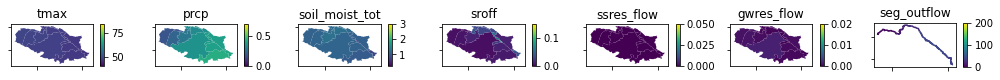

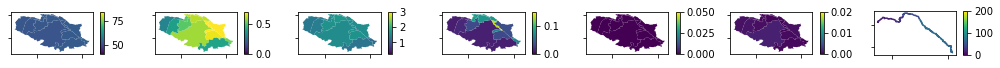

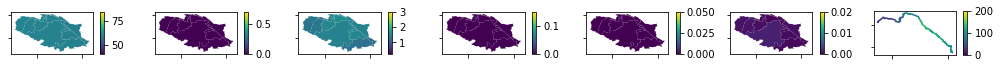

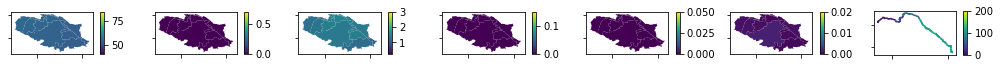

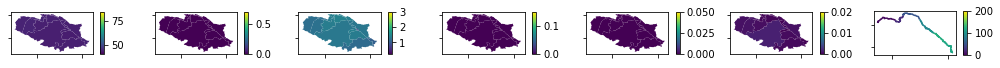

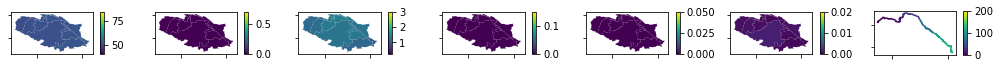

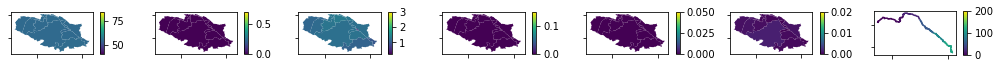

In [11]:

for i in range(7):
    update_coupled(msurf, msoil, mgw, msf, dprst_flag, imperv_flag)
    ptime = msurf.var['nowtime'].data
    timesel = dt.datetime(ptime[0], ptime[1], ptime[2])
    print(ptime, timesel)
    helper.example_plot_strm(clim, gdf_ps, gdf_streams, msurf, msoil, mgw, msf, i, timesel)
#     helper.example_plot(clim, gdf_ps, msurf, msoil, i, timesel)

In [12]:
for i in range(14):
    update_coupled(msurf, msoil, mgw, msf, dprst_flag, imperv_flag)
    ptime = msurf.var['nowtime'].data
    timesel = dt.datetime(ptime[0], ptime[1], ptime[2])
    print(ptime, timesel)

[1981    4    7    0    0    0] 1981-04-07 00:00:00
[1981    4    8    0    0    0] 1981-04-08 00:00:00
[1981    4    9    0    0    0] 1981-04-09 00:00:00
[1981    4   10    0    0    0] 1981-04-10 00:00:00
[1981    4   11    0    0    0] 1981-04-11 00:00:00
[1981    4   12    0    0    0] 1981-04-12 00:00:00
[1981    4   13    0    0    0] 1981-04-13 00:00:00
[1981    4   14    0    0    0] 1981-04-14 00:00:00
[1981    4   15    0    0    0] 1981-04-15 00:00:00
[1981    4   16    0    0    0] 1981-04-16 00:00:00
[1981    4   17    0    0    0] 1981-04-17 00:00:00
[1981    4   18    0    0    0] 1981-04-18 00:00:00
[1981    4   19    0    0    0] 1981-04-19 00:00:00
[1981    4   20    0    0    0] 1981-04-20 00:00:00


### Drive climate forcing with web-based data services - here Gridmet
* Pull Gridmet data from web-service for specified period and map to HRUs

In [13]:
print(msurf.get_value('nowtime'))

[1981    4   20    0    0    0]


In [14]:
# initialize Gridmet data service
gmdata = Gridmet("1981-04-21", end_date="1981-05-04", hrumap=True, hru_id=msurf.get_value('nhm_id'), wght_file=weight_file)

In [15]:
tmp = (gmdata.precip.data[0,:]*.0393701).astype(np.float32)
tmp


array([ 0.06168335,  0.08204757,  0.05656301,  0.04975373,  0.06551568,
        0.07198723,  0.06741221,  0.07112075,  0.07539704,  0.06989434,
        0.07431586,  0.07703177,  0.05697304,  0.06369118], dtype=float32)

In [16]:
tmp2 = msurf.get_value('hru_ppt')
tmp2


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

[1981    4   21    0    0    0] 1981-04-21 00:00:00
[1981    4   22    0    0    0] 1981-04-22 00:00:00
[1981    4   23    0    0    0] 1981-04-23 00:00:00
[1981    4   24    0    0    0] 1981-04-24 00:00:00
[1981    4   25    0    0    0] 1981-04-25 00:00:00
[1981    4   26    0    0    0] 1981-04-26 00:00:00
[1981    4   27    0    0    0] 1981-04-27 00:00:00
[1981    4   28    0    0    0] 1981-04-28 00:00:00
[1981    4   29    0    0    0] 1981-04-29 00:00:00
[1981    4   30    0    0    0] 1981-04-30 00:00:00
[1981    5    1    0    0    0] 1981-05-01 00:00:00
[1981    5    2    0    0    0] 1981-05-02 00:00:00
[1981    5    3    0    0    0] 1981-05-03 00:00:00
[1981    5    4    0    0    0] 1981-05-04 00:00:00


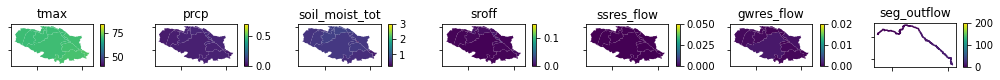

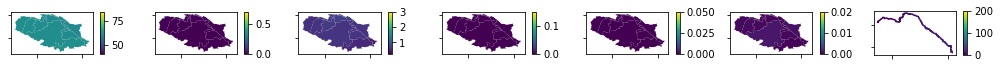

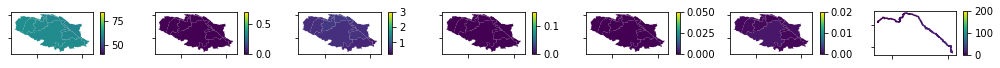

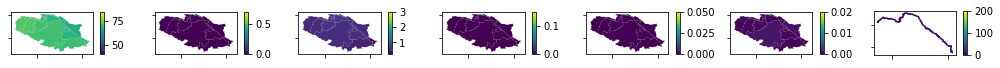

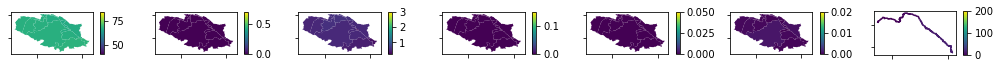

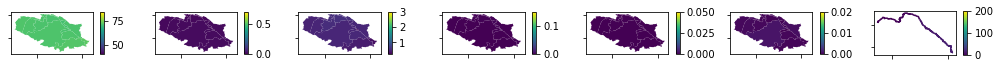

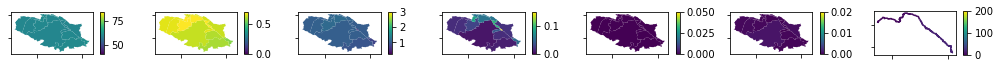

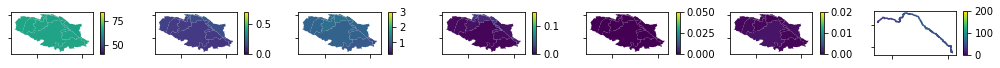

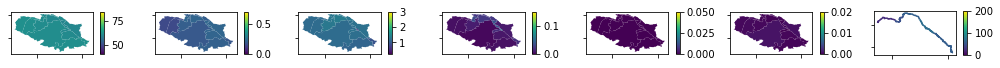

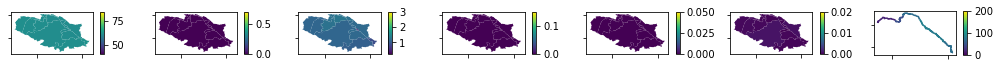

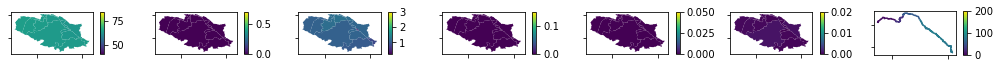

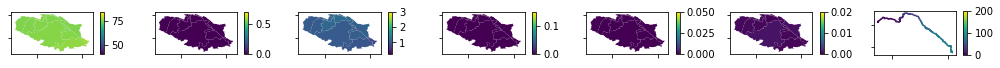

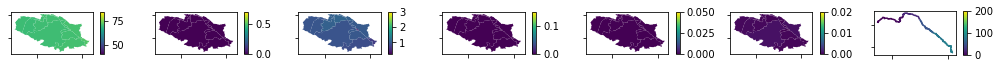

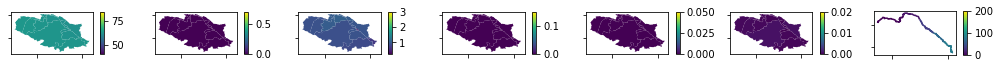

In [17]:
from helper import gm_example_plot
    
for i in np.arange(14):
#     tmp_p = msurf.get_value('hru_ppt')
#     tmp_tmax = msurf.get_value('tmax')
#     tmp_tmin = msurf.get_value('tmin')
#     tmp_p[:] = gmdata.precip.data[i,:]*.0393701
#     tmp_tmax[:] = (gmdata.tmax.data[i,:]*(9./5.))+32.0
#     tmp_tmin[:] = (gmdata.tmin.data[i,:]*(9./5.))+32.0
    msurf.set_value('hru_ppt', (gmdata.precip.data[i,:]*.0393701).astype(np.float32))
    msurf.set_value('tmax', ((gmdata.tmax.data[i,:]*(9./5.))+32.0).astype(np.float32))
    msurf.set_value('tmin', ((gmdata.tmin.data[i,:]*(9./5.))+32.0).astype(np.float32))
#     print(gmdata.precip[i,:]*.0393701)
#     print((gmdata.tmax[i,:]*(9/5))+32.0)
#     print((gmdata.tmin[i,:]*(9/5))+32.0)    
    update_coupled(msurf, msoil, mgw, msf, dprst_flag, imperv_flag)
    ptime = msurf.var['nowtime'].data
    timesel = dt.datetime(ptime[0], ptime[1], ptime[2])
    print(ptime, timesel)
#     print(gmdata.precip.data[i,:]*.0393701)
    helper.example_plot_strm(clim, gdf_ps, gdf_streams, msurf, msoil, mgw, msf, i, timesel)

---
In the next cell the precipitation, normally read from the netCDF file is overridden with user defined values.  Here we kick one HRU with a large amount of precipt, 3", and view the response

---

[1981    5    5    0    0    0] 1981-05-05 00:00:00
[1981    5    6    0    0    0] 1981-05-06 00:00:00
[1981    5    7    0    0    0] 1981-05-07 00:00:00
[1981    5    8    0    0    0] 1981-05-08 00:00:00
[1981    5    9    0    0    0] 1981-05-09 00:00:00
[1981    5   10    0    0    0] 1981-05-10 00:00:00
[1981    5   11    0    0    0] 1981-05-11 00:00:00
[1981    5   12    0    0    0] 1981-05-12 00:00:00
[1981    5   13    0    0    0] 1981-05-13 00:00:00
[1981    5   14    0    0    0] 1981-05-14 00:00:00
[1981    5   15    0    0    0] 1981-05-15 00:00:00
[1981    5   16    0    0    0] 1981-05-16 00:00:00
[1981    5   17    0    0    0] 1981-05-17 00:00:00
[1981    5   18    0    0    0] 1981-05-18 00:00:00


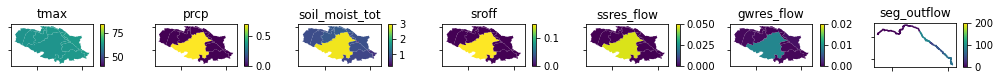

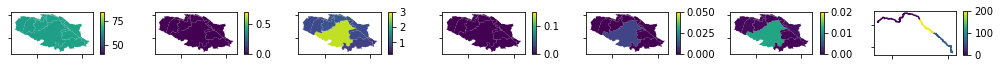

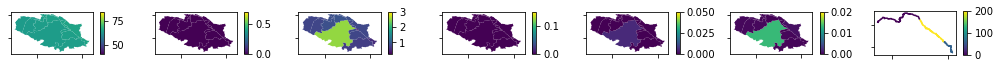

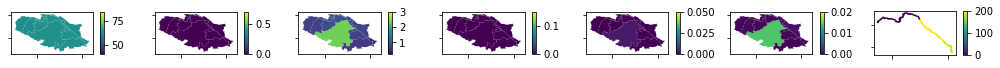

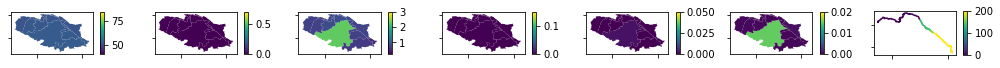

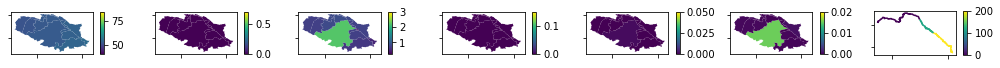

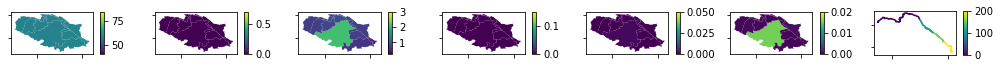

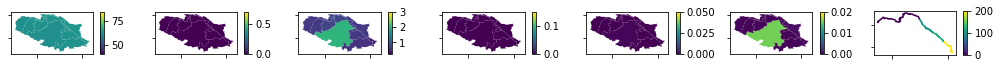

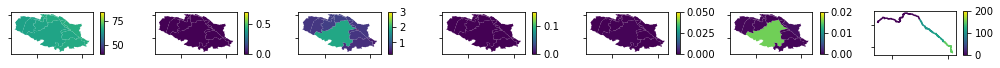

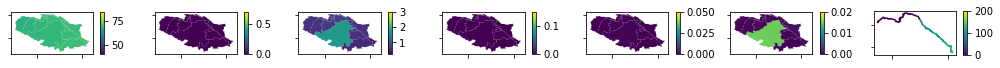

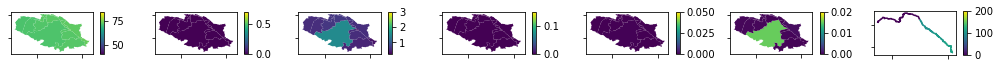

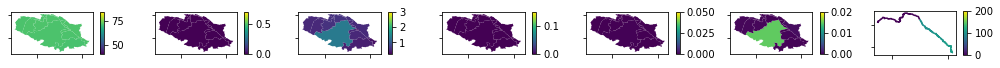

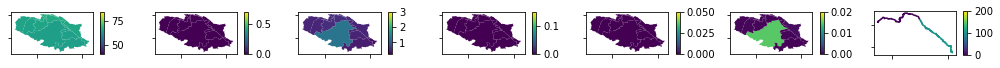

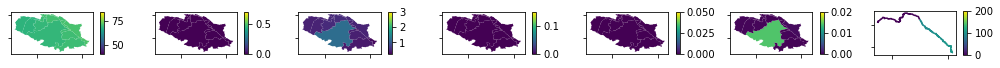

In [18]:

for i in range(14):
    if i == 0:
        grid_id = msurf.var_grid('hru_ppt')
        var_type = msurf.var_type('hru_ppt')
        grid_size = msurf.grid_node_count(grid_id)
        ppt_override = np.zeros(shape = (grid_size), dtype=var_type)
        ppt_override[0] = 3.0
        msurf.set_value('hru_ppt', ppt_override)
        
    update_coupled(msurf, msoil, mgw, msf, dprst_flag, imperv_flag)
    ptime = msurf.var['nowtime'].data
    timesel = dt.datetime(ptime[0], ptime[1], ptime[2])
    print(ptime, timesel)
    helper.example_plot_strm(clim, gdf_ps, gdf_streams, msurf, msoil, mgw, msf, i, timesel)

In [19]:
msoil.time

504.0

490.0 504.0


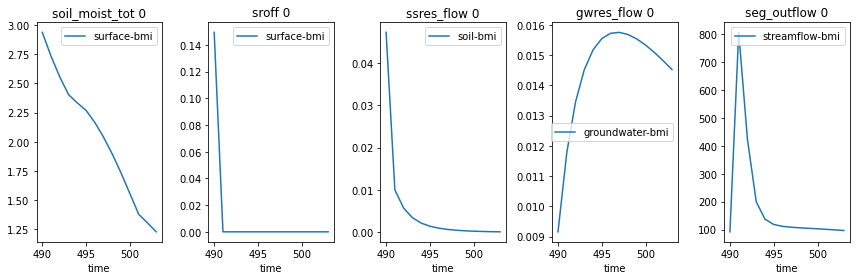

In [20]:
t_hru = 0
t_seg = 0
start_date = msoil.time-14
end_date = msoil.time
print(start_date, end_date)
import xarray as xr
surface_file = Path('../prms/pipestem/output/summary_surf_daily.nc')
soil_file = Path('../prms/pipestem/output/summary_soil_daily.nc')
gw_file = Path('../prms/pipestem/output/summary_gw_daily.nc')
strm_file = Path('../prms/pipestem/output/summary_sf_daily.nc')
dsurf = xr.open_dataset(surface_file, decode_times=False)
dsoil = xr.open_dataset(soil_file,  decode_times=False)
dgw = xr.open_dataset(gw_file,  decode_times=False)
dsf = xr.open_dataset(strm_file,  decode_times=False)

fig, ax = plt.subplots(ncols=5, figsize=(12,4))
helper.bmi_prms6_value_plot(dsoil, t_hru, 'soil_moist_tot', 'surface-bmi', start_date, end_date, ax[0])
helper.bmi_prms6_value_plot(dsurf, t_hru, 'sroff', 'surface-bmi', start_date, end_date, ax[1])
helper.bmi_prms6_value_plot(dsoil, t_hru, 'ssres_flow', 'soil-bmi', start_date, end_date, ax[2])
helper.bmi_prms6_value_plot(dgw, t_hru, 'gwres_flow', 'groundwater-bmi', start_date, end_date, ax[3])
helper.bmi_prms6_value_plot(dsf, t_seg, 'seg_outflow', 'streamflow-bmi', start_date, end_date, ax[4])
plt.tight_layout()
plt.show()


In [21]:
msurf.finalize()
msoil.finalize()
mgw.finalize()
msf.finalize()